In [28]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from io import BytesIO
import base64
import warnings
import io
warnings.filterwarnings('ignore')
# Function to encode a plot to a base64 string
def encode_plot_to_base64(plt):
    buf = BytesIO()
    plt.savefig(buf, format='png')
    buf.seek(0)
    image_base64 = base64.b64encode(buf.read()).decode('utf-8')
    buf.close()
    return image_base64

# Function to generate tables and charts for different combinations of parameters
def generate_analysis(df, delta_t_range, transaction_costs_range, selected_order_columns, period):
    results = []

 # Filter data based on the period (years)


    for delta_t in delta_t_range:
        for transaction_cost in transaction_costs_range:
            for order_column in selected_order_columns:
                df_copy=df
                df_copy = df_copy[df_copy['date'].dt.year >= (df_copy['date'].dt.year.max() - period + 1)]
                # Compute log returns if not present
                if 'log_return' not in df_copy.columns:
                     df_copy['log_return'] = np.log( df_copy['Close'] /  df_copy['Close'].shift(1))

                # Data preprocessing for the given parameters
                df_copy["N"] =  df_copy[order_column].rolling(window=delta_t).mean().shift(1)
                df_copy["n"] = df_copy[order_column] - df_copy["N"]
                df_copy['order'] = 0
                df_copy['order'][df_copy[order_column] > df_copy["N"].shift(1)] = 1  # Shorting if cross-over
                df_copy['order'][df_copy[order_column] < df_copy["N"].shift(1)] = -1  # Buying otherwise.
                df_copy['order'].iloc[:delta_t] = 0
                #df_copy = df_copy.dropna()

                # Compute log returns
                df_copy['log_returns'] = df_copy['order'] * df_copy['log_return'] - transaction_cost
                df_copy['log_returns_bh'] = df_copy['log_return']

                # Cumulated Returns
                df_copy['Sentiment Cumulated Returns'] = df_copy['log_returns'].cumsum()
                df_copy['Buy and Hold Cumulated Returns'] = df_copy['log_returns_bh'].cumsum()

                # Plotting
                plt.figure(figsize=(10, 6))
                plt.plot(df_copy['date'], df_copy['Sentiment Cumulated Returns'], color="red", label=order_column, linewidth=3)
                plt.plot(df_copy['date'], df_copy['Buy and Hold Cumulated Returns'], color="blue", label="Buy and Hold", linewidth=3)
                #plt.legend()
                plt.title(f"Cumulated Returns (delta_t={delta_t}, transaction_cost={transaction_cost}, order_column={order_column})")
                plt.xlabel("Date")
                plt.ylabel("Cumulated Log Return")
                # Save and encode
                buf = io.BytesIO()
                plt.savefig(buf,format='png', transparent=True, bbox_inches='tight', dpi=300)
                buf.seek(0)
                image_base64 = base64.b64encode(buf.read()).decode('utf-8')
                buf.close()
                plt.close()

                # Save results
                results.append({

                    'delta_t': delta_t,
                    'order_column': order_column,
                    'transaction_cost': transaction_cost,
                    'cumulated_returns_table': df_copy[['date', 'log_returns','Sentiment Cumulated Returns', 'Buy and Hold Cumulated Returns']].copy(),
                    'cumulated_returns_chart': image_base64
                })

                # Clear the plot for the next iteration
                plt.close()

    return results

# Load the dataset
df = pd.read_csv('btc_sentiment_predictions.csv')
df['date'] = pd.to_datetime(df['date'])

# Parameters for the analysis
reduced_delta_t_range = [1, 7, 14, 21, 30]  # Selected delta_t values
reduced_transaction_costs_range = [0.001, 0.002, 0.01]  # Selected transaction costs

# Exclude 'price' and 'volume' from the rolling mean calculation
exclude_columns = ['Close', 'Volume', 'Open',	'High', 'Low', 'Adj Close', 'pct_change', 'log_return','date']


# Select columns for the rolling mean calculation
selected_order_columns= [col for col in df.columns if col not in exclude_columns]

period = 1  # Focusing on the most recent year

# Run the optimized analysis
optimized_results = generate_analysis(df, reduced_delta_t_range, reduced_transaction_costs_range, selected_order_columns,period)

# Example: Accessing the first result
first_result = optimized_results[0]
# The first result contains 'cumulated_returns_table' and 'cumulated_returns_chart'


In [29]:
import matplotlib.pyplot as plt
import base64
import os
import io
# Function to save the chart with a transparent background
def save_chart_with_transparency(chart_base64, filename):
    chart_image = base64.b64decode(chart_base64)
    plt.imshow(plt.imread(io.BytesIO(chart_image), format='PNG'))
    plt.axis('off')

    plt.savefig(filename, bbox_inches='tight', pad_inches=0, transparent=True)
    plt.close()

# Directory paths for charts and tables
charts_dir = 'charts'
tables_dir = 'tables'

# Create directories if they do not exist
os.makedirs(charts_dir, exist_ok=True)
os.makedirs(tables_dir, exist_ok=True)

# Iterate through the results to save charts and tables
for i, result in enumerate(optimized_results):
    # Save Chart with transparent background
    chart_file_path = os.path.join(charts_dir, f"chart_{i}.png")
    save_chart_with_transparency(result['cumulated_returns_chart'], chart_file_path)

    # Save Table
    table_file_path = os.path.join(tables_dir, f"table_{i}.csv")
    result['cumulated_returns_table'].to_csv(table_file_path, index=False)

print("Charts with transparent background and tables have been saved.")



Charts with transparent background and tables have been saved.


In [30]:
def calculate_performance_metrics(df):
    """
    Calculate performance metrics for a given trading strategy.
    :param df: DataFrame with strategy results.
    :return: Dictionary with calculated metrics.
    """
    # Calculate log returns
    log_returns = df['log_returns']

    # Total Cumulative Return
    final_cumulated_return = df['Sentiment Cumulated Returns'].iloc[-1]
    bh_cumulated_return=   df['Buy and Hold Cumulated Returns'].iloc[-1]
    # Sharpe Ratio (assuming risk-free rate = 0 for simplicity)
    # Adjust the risk-free rate as needed
    risk_free_rate = 0
    sharpe_ratio = (log_returns.mean() - risk_free_rate) / log_returns.std()

    # Maximum Drawdown
    rolling_max = df['Sentiment Cumulated Returns'].cummax()
    drawdown = (df['Sentiment Cumulated Returns'] - rolling_max) / rolling_max
    max_drawdown = drawdown.min()

    # Volatility (Standard Deviation of Returns)
    volatility = log_returns.std()

    return {
        'final_cumulated_return': final_cumulated_return,
        'bh_cumulated_return': bh_cumulated_return,
        'sharpe_ratio': sharpe_ratio,
        'max_drawdown': max_drawdown,
        'volatility': volatility
    }

# Assuming `results` is the output of your `generate_analysis` function
strategy_metrics = []

for result in optimized_results:
    df = result['cumulated_returns_table']
    metrics = calculate_performance_metrics(df)
    strategy_metrics.append({
        'delta_t': result['delta_t'],
        'order_column': result['order_column'],
        'transaction_cost': result['transaction_cost'],
        **metrics  # Unpack the metrics dictionary correctly
    })

# Selecting the best strategy based on a chosen metric (e.g., highest Sharpe ratio)
best_strategy = max(strategy_metrics, key=lambda x: x['final_cumulated_return'])
print("Best Strategy:", best_strategy)


Best Strategy: {'delta_t': 14, 'order_column': 'compound_sentiment', 'transaction_cost': 0.001, 'final_cumulated_return': 0.8112093426338046, 'bh_cumulated_return': 0.4954977053508497, 'sharpe_ratio': 0.1325131850772794, 'max_drawdown': -3.167492120559817, 'volatility': 0.02125599127909216}


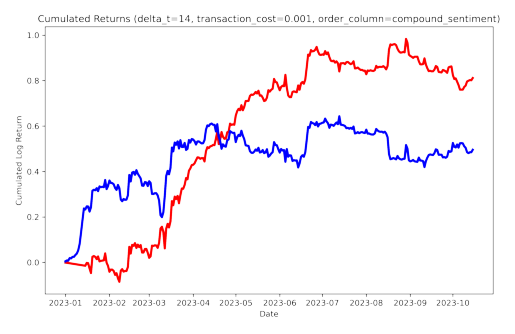

In [31]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import io

# Assuming the previous steps have been completed and 'best_strategy' is determined

# Find the corresponding chart in the original results
best_chart_base64 = None
for result in optimized_results:
    if result['delta_t'] == best_strategy['delta_t'] and \
       result['order_column'] == best_strategy['order_column'] and \
       result['transaction_cost'] == best_strategy['transaction_cost']:
        best_chart_base64 = result['cumulated_returns_chart']
        break

# Decode and display the chart image
if best_chart_base64:
    chart_image = base64.b64decode(best_chart_base64)
    chart_image = io.BytesIO(chart_image)
    img = mpimg.imread(chart_image, format='PNG')

    plt.imshow(img)
    plt.axis('off')  # Turn off axis numbers and labels
    plt.show()
else:
    print("Chart not found for the best strategy.")


In [32]:
import pandas as pd

# Sorting the strategies based on a criterion, e.g., Sharpe Ratio
sorted_strategies = sorted(strategy_metrics, key=lambda x: x['final_cumulated_return'], reverse=True)

# Now, converting the sorted strategies to a DataFrame
strategy_metrics_df = pd.DataFrame(sorted_strategies)

# Selecting the top strategies, for example, the top 10
top_strategies_df = strategy_metrics_df.head(10)

# Convert the sorted strategy metrics to a DataFrame
strategy_metrics_df = pd.DataFrame(sorted_strategies)

# Select the top 10 strategies
top_strategies_df = strategy_metrics_df.head(10)

# Display the table
print(top_strategies_df)


   delta_t           order_column  transaction_cost  final_cumulated_return  \
0       14     compound_sentiment             0.001                0.811209   
1        7     compound_sentiment             0.001                0.742566   
2        7  final_sentiment_score             0.001                0.728028   
3       21     compound_sentiment             0.001                0.673527   
4       30      weighted_compound             0.001                0.602208   
5       30  final_sentiment_score             0.001                0.573396   
6        7      weighted_compound             0.001                0.531609   
7       14     compound_sentiment             0.002                0.523209   
8        1     compound_sentiment             0.001                0.516655   
9        7    sentiment_intensity             0.001                0.488933   

   bh_cumulated_return  sharpe_ratio  max_drawdown  volatility  
0             0.495498      0.132513     -3.167492    0.021256  
